In [4]:
import pandas as pd
import numpy as np

In [8]:
message=pd.read_csv('dataset.csv')
message.head()

,text,label
0,oh my gosh,1.0
1,"trouble sleeping, confused mind, restless hear...",1.0
2,"All wrong, back off dear, forward doubt. Stay ...",1.0
3,I've shifted my focus to something else but I'...,1.0
4,"I'm restless and restless, it's been a month n...",1.0


## Exploratory Data Analysis

In [9]:
message.isnull().sum()

text     0
label    2
dtype: int64

In [10]:
message['text'] = message['text'].fillna('oh my gosh')

In [11]:
message['label'] = message['label'].fillna(0)

In [12]:
message.isnull().sum()

text     0
label    0
dtype: int64

In [13]:
# converting 'Field_2' from float to int
message['label'] = message['label'].apply(np.int64)

In [14]:
message.describe()

,label
count,6982.000000
mean,0.104984
std,0.306555
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [15]:
message.groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
0      6249   6184                                     ni-ki best boy   11
1       733    713  "No regrets or grudges/angry at things that ha...    5

In [16]:
message['length']=message['text'].str.len()
message.head()

,text,label,length
0,oh my gosh,1,10
1,"trouble sleeping, confused mind, restless hear...",1,64
2,"All wrong, back off dear, forward doubt. Stay ...",1,78
3,I've shifted my focus to something else but I'...,1,61
4,"I'm restless and restless, it's been a month n...",1,72


### Data Visualization
Let's visualize this! Let's do the imports:

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<Axes: ylabel='Frequency'>

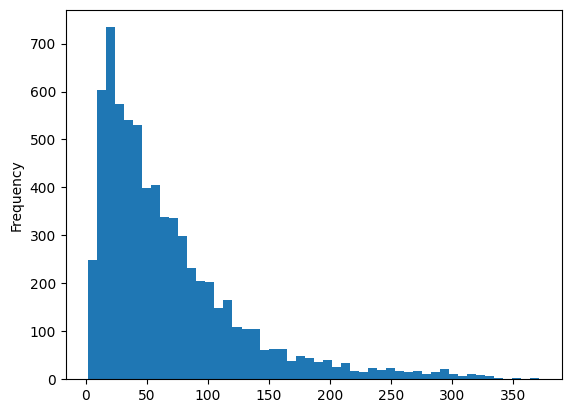

In [20]:
message['length'].plot(bins=50,kind='hist')

In [21]:
message.length.describe()

count    6982.000000
mean       68.397737
std        59.120715
min         2.000000
25%        26.000000
50%        51.000000
75%        90.000000
max       371.000000
Name: length, dtype: float64

Woah! 910 characters, let's use masking to find this message:

In [22]:
message[message['length']==200]['text'].iloc[0]

"um! Pls, how do I feel afraid to go out of the house because I'm afraid to meet people, I don't know why, even though I wasn't like this before, I used to be nervous, then I'm so anxious I'm so sweaty"

Looks like we have some sort of Romeo sending texts! But let's focus back on the idea of trying to see if message length is a distinguishing feature between ham and spam

## Text Pre-processing

In [24]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [25]:
from nltk.corpus import stopwords
stopwords.words('english')[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

Now let's put both of these together in a function to apply it to our DataFrame later on:

In [26]:
import string

In [27]:
def text_process(mess):
    nopunc =[char for char in mess if char not in string.punctuation]
    nopunc=''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

Here is the original DataFrame again:

In [28]:
message.head()

,text,label,length
0,oh my gosh,1,10
1,"trouble sleeping, confused mind, restless hear...",1,64
2,"All wrong, back off dear, forward doubt. Stay ...",1,78
3,I've shifted my focus to something else but I'...,1,61
4,"I'm restless and restless, it's been a month n...",1,72


In [29]:
message['text'].head(5).apply(text_process)

0                                           [oh, gosh]
1    [trouble, sleeping, confused, mind, restless, ...
2    [wrong, back, dear, forward, doubt, Stay, rest...
3    [Ive, shifted, focus, something, else, Im, sti...
4           [Im, restless, restless, month, boy, mean]
Name: text, dtype: object

In [30]:
message.head()

,text,label,length
0,oh my gosh,1,10
1,"trouble sleeping, confused mind, restless hear...",1,64
2,"All wrong, back off dear, forward doubt. Stay ...",1,78
3,I've shifted my focus to something else but I'...,1,61
4,"I'm restless and restless, it's been a month n...",1,72


### Continuing Normalization

## Vectorization

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

Let's take one text message and get its bag-of-words counts as a vector, putting to use our new `bow_transformer`:

In [32]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(message['text'].values.astype('U'))
print(len(bow_transformer.vocabulary_))

14174


In [33]:
message4=message['text'][3]
print(message4)

I've shifted my focus to something else but I'm still worried


Now let's see its vector representation:

In [34]:
bow4=bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 2286)	1
  (0, 2350)	1
  (0, 7121)	1
  (0, 7549)	1
  (0, 11827)	1
  (0, 12081)	1
  (0, 12251)	1
  (0, 13504)	1
(1, 14174)


This means that there are seven unique words in message number 4 (after removing common stop words). Two of them appear twice, the rest only once. Let's go ahead and check and confirm which ones appear twice:

In [35]:
print(bow_transformer.get_feature_names_out()[4073])
print(bow_transformer.get_feature_names_out()[9570])

Sooyoung
mascara


Now we can use **.transform** on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of messages. Let's go ahead and check out how the bag-of-words counts for the entire SMS corpus is a large, sparse matrix:

In [36]:
messages_bow = bow_transformer.transform(message['text'].values.astype('U'))

In [37]:
print('Shape of Sparse Matrix: ',messages_bow.shape)
print('Amount of non-zero occurences:',messages_bow.nnz)

Shape of Sparse Matrix:  (6982, 14174)
Amount of non-zero occurences: 48839


In [38]:
sparsity =(100.0 * messages_bow.nnz/(messages_bow.shape[0]*messages_bow.shape[1]))
print('sparsity:{}'.format(round(sparsity)))

sparsity:0


In [39]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer=TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 13504)	0.30017223005394456
  (0, 12251)	0.2564115535275223
  (0, 12081)	0.33751864181027913
  (0, 11827)	0.5289318113790635
  (0, 7549)	0.4125596545381498
  (0, 7121)	0.387872321486873
  (0, 2350)	0.30415696241065315
  (0, 2286)	0.19313256781993693


We'll go ahead and check what is the IDF (inverse document frequency) of the word `"u"` and of word `"university"`?

In [40]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['restless']])

7.286284545384499
4.313899635827498


In [41]:
messages_tfidf=tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(6982, 14174)


## Training a model

In [42]:
from sklearn.naive_bayes import MultinomialNB
detect_model = MultinomialNB().fit(messages_tfidf,message['label'])

In [43]:
print('predicted:',detect_model.predict(tfidf4)[0])
print('expected:',message.label[3])

predicted: 0
expected: 1


## Part 6: Model Evaluation


In [44]:
all_predictions = detect_model.predict(messages_tfidf)
print(all_predictions)

[0 0 0 ... 0 0 0]


We can use SciKit Learn's built-in classification report, which returns [precision, recall,](https://en.wikipedia.org/wiki/Precision_and_recall) [f1-score](https://en.wikipedia.org/wiki/F1_score), and a column for support (meaning how many cases supported that classification). Check out the links for more detailed info on each of these metrics and the figure below:

In [45]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(message['label'],all_predictions))
print(confusion_matrix(message['label'],all_predictions))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      6249
           1       1.00      0.24      0.38       733

    accuracy                           0.92      6982
   macro avg       0.96      0.62      0.67      6982
weighted avg       0.93      0.92      0.90      6982

[[6249    0]
 [ 560  173]]


In [46]:
from sklearn.model_selection import train_test_split
msg_train,msg_test,label_train,label_test = train_test_split(message['text'],message['label'],test_size=0.2)

In [47]:
print(len(msg_train),len(msg_test),len(label_train),len(label_test))

5585 1397 5585 1397


In [48]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
   ( 'bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB()),
])

In [49]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x000002B0A73D9580>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [50]:
predictions = pipeline.predict(msg_test)

In [51]:
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95      1375
           1       0.15      1.00      0.27        22

    accuracy                           0.91      1397
   macro avg       0.58      0.96      0.61      1397
weighted avg       0.99      0.91      0.94      1397



GENETIC ALGORITHM

In [52]:
import random
from nltk.sentiment import SentimentIntensityAnalyzer

In [53]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...


True

In [58]:
# Step 1: Prepare the initial population
def create_population(size, length):
    population = []
    for _ in range(size):
        individual = [random.choice([0, 1]) for _ in range(length)]
        population.append(individual)
    return population

# Step 2: Evaluate the fitness of each individual
def evaluate_fitness(population, data):
    fitness_scores = []
    for individual in population:
        sentiment = calculate_sentiment(data, individual)
        fitness_scores.append(sentiment)
    return fitness_scores

# Step 3: Select parents for reproduction
def selection(population, fitness_scores):
    total_fitness = sum(fitness_scores)
    # Check if total fitness is zero, return random parents if so
    if total_fitness == 0:
        return random.choices(population, k=len(population))
    probabilities = [fitness / total_fitness for fitness in fitness_scores]
    selected_parents = random.choices(population, probabilities, k=len(population))
    return selected_parents

# Step 4: Perform crossover to create offspring
def crossover(parent1, parent2):
    point = random.randint(1, len(parent1) - 1)
    offspring1 = parent1[:point] + parent2[point:]
    offspring2 = parent2[:point] + parent1[point:]
    return offspring1, offspring2

# Step 5: Perform mutation on the offspring
def mutation(individual, mutation_rate):
    mutated_individual = []
    for gene in individual:
        if random.random() < mutation_rate:
            gene = 1 - gene  # Flip the bit
        mutated_individual.append(gene)
    return mutated_individual

# Step 6: Run the genetic algorithm
def genetic_algorithm(data, population_size, num_generations, mutation_rate):
    population = create_population(population_size, len(data))
    for generation in range(num_generations):
        fitness_scores = evaluate_fitness(population, data)
        parents = selection(population, fitness_scores)
        new_population = []
        while len(new_population) < population_size:
            parent1, parent2 = random.sample(parents, 2)
            offspring1, offspring2 = crossover(parent1, parent2)
            offspring1 = mutation(offspring1, mutation_rate)
            offspring2 = mutation(offspring2, mutation_rate)
            new_population.extend([offspring1, offspring2])
        population = new_population
    best_individual = max(population, key=lambda ind: calculate_sentiment(data, ind))
    return best_individual

# Step 7: Calculate sentiment based on individual
def calculate_sentiment(data, individual):
    sid = SentimentIntensityAnalyzer()
    sentiment_score = sid.polarity_scores(data)["compound"]
    return sentiment_score

In [59]:
data = message['text'].head(10)

In [61]:
population_size = 50
num_generations = 100
mutation_rate = 0.01
mess = []
for i in range(len(data)):
  best_individual = genetic_algorithm(data[i], population_size, num_generations, mutation_rate)
  best_sentiment = calculate_sentiment(data[i], best_individual)
  mess.append(best_sentiment)
print("Best sentiment:", mess)

Best sentiment: [0.0, -0.7269, -0.7351, -0.4215, -0.4939, -0.2144, 0.25, -0.1406, -0.1063, -0.6142]


In [62]:
OptimizeEmotional = np.array(mess)

In [63]:
message = message.head(10)

In [64]:
message.insert(3, "OptimizeEmotional", OptimizeEmotional)

In [65]:
message

,text,label,length,OptimizeEmotional
0,oh my gosh,1,10,0.0000
1,"trouble sleeping, confused mind, restless hear...",1,64,-0.7269
2,"All wrong, back off dear, forward doubt. Stay ...",1,78,-0.7351
3,I've shifted my focus to something else but I'...,1,61,-0.4215
4,"I'm restless and restless, it's been a month n...",1,72,-0.4939
5,"every break, you must be nervous, like somethi...",1,76,-0.2144
6,"I feel scared, anxious, what can I do? And may...",1,78,0.2500
7,Have you ever felt nervous but didn't know why?,1,47,-0.1406
8,"I haven't slept well for 2 days, it's like I'm...",1,70,-0.1063
9,"I'm really worried, I want to cry.",1,34,-0.6142


USER INPUT

In [66]:
input = "i will love you."

In [67]:
data = input
population_size = 50
num_generations = 100
mutation_rate = 0.01
best_individual = genetic_algorithm(data, population_size, num_generations, mutation_rate)
best_sentiment = calculate_sentiment(data, best_individual)
print("Best sentiment:", best_sentiment)

Best sentiment: 0.6369


In [68]:
!pip install vaderSentiment

   ---------------------------------------- 0.0/126.0 kB ? eta -:--:--
   -------------------------- ------------- 81.9/126.0 kB 2.3 MB/s eta 0:00:01
   ---------------------------------------- 126.0/126.0 kB 2.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/63.9 kB ? eta -:--:--
   ---------------------------------------- 63.9/63.9 kB 3.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/163.8 kB ? eta -:--:--
   ---------------------------------------- 163.8/163.8 kB 9.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/100.4 kB ? eta -:--:--
   ---------------------------------------- 100.4/100.4 kB ? eta 0:00:00
   ---------------------------------------- 0.0/66.8 kB ? eta -:--:--
   ---------------------------------------- 66.8/66.8 kB 3.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/121.1 kB ? eta -:--:--
   ---------------------------------------- 121.1/121.1 kB 7.4 MB/s eta 0:00:00


In [69]:
# Vader sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # for polarity score
analyser = SentimentIntensityAnalyzer()


def pos(tweet):
    SentDict = analyser.polarity_scores(tweet)
    return SentDict['pos']

def neg(tweet):
    SentDict = analyser.polarity_scores(tweet)
    return SentDict['neg']

def neu(tweet):
    SentDict = analyser.polarity_scores(tweet)
    return SentDict['neu']

In [71]:
from sklearn.feature_extraction import text
import string
stop = text.ENGLISH_STOP_WORDS
message['text'] = message['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
#rahul_df['Tweet'] = rahul_df['Tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

message['text'] = message['text'].apply(remove_punctuations)
#rahul_df['Tweet'] = rahul_df['Tweet'].apply(remove_punctuations)

In [72]:
message['pos'] = message['text'].apply(lambda x :pos(x))
message['neg'] = message['text'].apply(lambda x :neg(x))
message['neu'] = message['text'].apply(lambda x :neu(x))

In [74]:
emotion=[]
for i in range(0,len(message)):
    emotion.append(max(message['pos'][i],message['neu'][i],message['neg'][i]))

message['FinalEmotion']=emotion


for i in range(0,len(message)):
    if message['FinalEmotion'][i]==message['pos'][i]:
        message['FinalEmotion'][i]='positive'
    elif message['FinalEmotion'][i]==message['neg'][i]:
        message['FinalEmotion'][i]='negative' 
    elif message['FinalEmotion'][i]==message['neu'][i]:
        message['FinalEmotion'][i]='neutral'
message

C:\Users\hp\AppData\Local\Temp\ipykernel_748\70986573.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  message['FinalEmotion'][i]='neutral'
C:\Users\hp\AppData\Local\Temp\ipykernel_748\70986573.py:14: SettingWithCopyWarning: 
A value is 

,text,label,length,OptimizeEmotional,pos,neg,neu,FinalEmotion
0,oh gosh,1,10,0.0000,0.000,0.000,1.000,neutral
1,trouble sleeping confused mind restless heart ...,1,64,-0.7269,0.275,0.464,0.261,negative
2,All wrong dear forward doubt Stay restless res...,1,78,-0.7351,0.159,0.598,0.244,negative
3,Ive shifted focus Im worried,1,61,-0.4215,0.000,0.355,0.645,neutral
4,Im restless restless month boy What mean,1,72,-0.4939,0.000,0.457,0.543,neutral
5,break nervous like wrong heck,1,76,-0.2144,0.258,0.536,0.206,negative
6,I feel scared anxious I And family protected,1,78,0.2500,0.227,0.383,0.391,neutral
7,Have felt nervous didnt know,1,47,-0.1406,0.000,0.344,0.656,neutral
8,I havent slept 2 days like Im restless huh,1,70,-0.1063,0.216,0.181,0.603,neutral
9,Im really worried I want,1,34,-0.6142,0.222,0.353,0.425,neutral
